In [6]:
import pandas as pd
from datetime import tzinfo, timedelta, datetime
import numpy as np
import tarfile
from io import StringIO
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error as MSRE
import itertools
from collections import Counter
import matplotlib.pylab as plt
import math
import scipy.stats as stats
import scipy.spatial.distance
from scipy.optimize import linear_sum_assignment
from __future__ import division

In [7]:
def get_datetime_str(unixtime):
    fmt_datetime=datetime.fromtimestamp(float(str(unixtime))).strftime('%Y-%m-%d %H:%M:%S')
    fmt_timezone = "+00:00"
    return fmt_datetime + fmt_timezone

print get_datetime_str(1529076383.0)

2018-06-15 08:26:23+00:00


In [8]:
node_2o = pd.read_csv("/home/users/tleibengood/Documents/2018Poject/data/mine/node_2.csv")
node_5o = pd.read_csv("/home/users/tleibengood/Documents/2018Poject/data/mine/node_5.csv")
node_6o = pd.read_csv("/home/users/tleibengood/Documents/2018Poject/data/mine/node_6.csv")
node_7o = pd.read_csv("/home/users/tleibengood/Documents/2018Poject/data/mine/node_7.csv")
node_8o = pd.read_csv("/home/users/tleibengood/Documents/2018Poject/data/mine/node_8.csv")

In [9]:
print node_2o.shape
print node_5o.shape
print node_6o.shape
print node_7o.shape
print node_8o.shape

(3952817, 105)
(363488, 105)
(506512, 105)
(480739, 105)
(456868, 105)


In [10]:
3952817+363488+506512+480739+456868

5760424

In [11]:
sc          = [65, 16, 64, 87, 61, -1]
sc_c1       = [64, 61, 65, 42, 70, -1]
sc_c2       = [64, 61, 65, 42, 4, -1]
sc_s        = [16, 87, 18, 84, 89, -1]
sc_rel      = [65, 18, 70, 27, 89, -1]
sc_c_rel    = [70, 65, 42, 68, 4, -1]
sc_s_rel    = [94, 31, 86, 90, 18, -1]
sc_no_ports = [64, 65, 87, 61, 18, -1]
euro        = ['s_pkts_retx:24', 's_pkts_all:17', 's_bytes_all:23', 'durat:31', 's_rtt_avg:52', 's_pkts_unk:100', 'first_time']
Mariam      = [65, 70, 89, 68, 99, -1]
Mariam_s    = [89, 99, 94, 88, 91, -1]
Mariam_c    = [70, 65, 68, 45, 71, -1]

sc[:]          = [x-1 for x in sc]
sc_c1[:]       = [x-1 for x in sc_c1]
sc_c2[:]       = [x-1 for x in sc_c2]
sc_s[:]        = [x-1 for x in sc_s]
sc_rel[:]      = [x-1 for x in sc_rel]
sc_c_rel[:]    = [x-1 for x in sc_c_rel]
sc_s_rel[:]    = [x-1 for x in sc_s_rel]
sc_no_ports[:] = [x-1 for x in sc_no_ports]
Mariam[:]      = [x-1 for x in Mariam]
Mariam_s[:]    = [x-1 for x in Mariam_s]
Mariam_c[:]    = [x-1 for x in Mariam_c]

In [12]:
#Data from May 1st til June 11th (12 am)

node_2o = node_2o[(node_2o['first:29'] > 1493596800000.0) &
                  (node_2o['first:29'] < 1497139200000.0)]
node_5o = node_5o[(node_5o['first:29'] > 1493596800000.0) &
                  (node_5o['first:29'] < 1497139200000.0)]
node_6o = node_6o[(node_6o['first:29'] > 1493596800000.0) &
                  (node_6o['first:29'] < 1497139200000.0)]
node_7o = node_7o[(node_7o['first:29'] > 1493596800000.0) &
                  (node_7o['first:29'] < 1497139200000.0)]
node_8o = node_8o[(node_8o['first:29'] > 1493596800000.0) &
                  (node_8o['first:29'] < 1497139200000.0)]

start_time = datetime(2017, 5, 1, 0, 0, 0)
switch_time = datetime(2017, 6, 1, 0, 0, 0)
end_time = datetime(2017, 6, 11, 0, 0, 0)

In [13]:
o = pd.concat([node_2o, node_5o, node_6o, node_7o, node_8o])

In [14]:
#unix time to datetime
def unix_to_dt(X) :
    standard_date = datetime.fromtimestamp(math.floor(X))
    adjusted = standard_date + timedelta(hours=7)
    return adjusted

In [15]:
o['first_time'] = (o['first:29']/1000).apply(lambda x: unix_to_dt(x,))

In [16]:
o['s_throughput'] = ((8000*o['s_bytes_all:23']) / o['durat:31'])
o = o[o['s_throughput'] != 0.0]

In [17]:
o = o.dropna()

In [18]:
o.iloc[:, [-2, -1]].head()

,first_time,s_throughput
2907422,2017-05-01 00:00:01,1.895792e+06
2907423,2017-05-01 00:00:01,1.521355e+05
2907424,2017-05-01 00:00:03,4.405716e+06
2907427,2017-05-01 00:01:00,1.364124e+06
2907430,2017-05-01 00:02:24,7.212969e+06


In [19]:
o_order=o.set_index(pd.DatetimeIndex(o['first_time'])).sort_index().loc[start_time:switch_time]

del o

In [20]:
o_order = o_order.drop(columns='Unnamed: 0')

In [21]:
o_order.head()

,#09#c_ip:1,c_port:2,c_pkts_all:3,c_rst_cnt:4,c_ack_cnt:5,c_ack_cnt_p:6,c_bytes_uniq:7,c_pkts_data:8,c_bytes_all:9,c_pkts_retx:10,...,s_pkts_fs:97,s_pkts_reor:98,s_pkts_dup:99,s_pkts_unk:100,s_pkts_fc:101,s_pkts_unrto:102,s_pkts_unfs:103,s_syn_retx:104,first_time,s_throughput
first_time,,,,,,,,,,,,,,,,,,,,,
2017-05-01 00:00:01,128.55.205.19,55812.0,13.0,0.0,12.0,6.0,7.660000e+02,5.0,7.660000e+02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-01 00:00:01,1.895792e+06
2017-05-01 00:00:01,128.55.210.52,43950.0,13.0,0.0,12.0,3.0,1.749000e+03,8.0,1.749000e+03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-01 00:00:01,1.521355e+05
2017-05-01 00:00:03,128.55.205.19,51316.0,286.0,0.0,285.0,283.0,1.630000e+02,1.0,1.630000e+02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-01 00:00:03,4.405716e+06
2017-05-01 00:01:00,128.55.211.24,51602.0,5.0,1.0,3.0,1.0,1.000000e+00,1.0,1.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-01 00:01:00,1.364124e+06
2017-05-01 00:02:23,131.243.37.2,45627.0,919533.0,0.0,919532.0,162.0,3.612900e+09,919369.0,3.612900e+09,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-05-01 00:02:23,7.727065e+05


In [22]:
c1       = o_order.iloc[:, sc_c1]
c2       = o_order.iloc[:, sc_c2]
s        = o_order.iloc[:, sc_s]
c_rel    = o_order.iloc[:, sc_c_rel]
s_rel    = o_order.iloc[:, sc_s_rel] 
Eeuro    = o_order.loc[:, euro]
df       = o_order.iloc[:, sc]
rel      = o_order.iloc[:, sc_rel]
no_ports = o_order.iloc[:, sc_no_ports]
s_mar    = o_order.iloc[:, Mariam_s]
o_tput   = o_order.loc[:, ['s_throughput', 'first_time']]

c1_cols       = list(c1.columns.values)
c2_cols       = list(c2.columns.values)
s_cols        = list(s.columns.values)
c_rel_cols    = list(c_rel.columns.values)
s_rel_cols    = list(s_rel.columns.values) 
Eeuro_cols    = list(Eeuro.columns.values)
df_cols       = list(df.columns.values)
rel_cols      = list(rel.columns.values)
no_ports_cols = list(no_ports.columns.values)
s_mar_cols    = list(s_mar.columns.values)
o_tput_cols   = list(o_tput.columns.values)

In [23]:
euro

['s_pkts_retx:24',
 's_pkts_all:17',
 's_bytes_all:23',
 'durat:31',
 's_rtt_avg:52',
 's_pkts_unk:100',
 'first_time']

In [24]:
Eeuro['packet_loss_rate'] = Eeuro.loc[:,'s_pkts_retx:24']/Eeuro.loc[:,'s_pkts_all:17']
Eeuro['packet_rate']      = Eeuro.loc[:,'s_pkts_unk:100']/Eeuro.loc[:,'s_pkts_all:17']
Eeuro['latency']          = Eeuro.loc[:,'s_rtt_avg:52']

In [25]:
Eeuro = Eeuro.drop(columns=list(euro[:6]))

In [26]:
c1.loc[:,['c_mss:64', 'c_win_scl:61', 'c_mss_max:65', 'con_t:42', 'c_cwin_max:70']]          = MinMaxScaler().fit_transform(c1.loc[:,['c_mss:64', 'c_win_scl:61', 'c_mss_max:65', 'con_t:42', 'c_cwin_max:70']])
c2.loc[:,['c_mss:64', 'c_win_scl:61', 'c_mss_max:65', 'con_t:42', 'c_rst_cnt:4']]            = MinMaxScaler().fit_transform(c2.loc[:,['c_mss:64', 'c_win_scl:61', 'c_mss_max:65', 'con_t:42', 'c_rst_cnt:4']])
s.loc[:,['s_port:16', 's_mss:87', 's_rst_cnt:18', 's_win_scl:84', 's_mss_min:89']]           = MinMaxScaler().fit_transform(s.loc[:,['s_port:16', 's_mss:87', 's_rst_cnt:18', 's_win_scl:84', 's_mss_min:89']])
c_rel.loc[:,['c_cwin_max:70', 'c_mss_max:65', 'con_t:42', 'c_win_min:68', 'c_rst_cnt:4']]    = MinMaxScaler().fit_transform(c_rel.loc[:,['c_cwin_max:70', 'c_mss_max:65', 'con_t:42', 'c_win_min:68', 'c_rst_cnt:4']])
s_rel.loc[:,['s_cwin_min:94', 'durat:31', 's_sack_cnt:86', 's_win_max:90', 's_rst_cnt:18']]  = MinMaxScaler().fit_transform(s_rel.loc[:,['s_cwin_min:94', 'durat:31', 's_sack_cnt:86', 's_win_max:90', 's_rst_cnt:18']])
Eeuro.loc[:,['packet_loss_rate', 'packet_rate', 'latency']]                                  = MinMaxScaler().fit_transform(Eeuro.loc[:,['packet_loss_rate', 'packet_rate', 'latency']])
df.loc[:,['c_mss_max:65', 's_port:16', 'c_mss:64', 's_mss:87', 'c_win_scl:61']]              = MinMaxScaler().fit_transform(df.loc[:,['c_mss_max:65', 's_port:16', 'c_mss:64', 's_mss:87', 'c_win_scl:61']])
rel.loc[:,['c_mss_max:65', 's_rst_cnt:18', 'c_cwin_max:70', 's_syn_cnt:27', 's_mss_min:89']] = MinMaxScaler().fit_transform(rel.loc[:,['c_mss_max:65', 's_rst_cnt:18', 'c_cwin_max:70', 's_syn_cnt:27', 's_mss_min:89']])
no_ports.loc[:,['c_mss:64', 'c_mss_max:65', 's_mss:87', 'c_win_scl:61', 's_rst_cnt:18']]     = MinMaxScaler().fit_transform(no_ports.loc[:,['c_mss:64', 'c_mss_max:65', 's_mss:87', 'c_win_scl:61', 's_rst_cnt:18']])
s_mar.loc[:,['s_mss_min:89','s_pkts_dup:99','s_cwin_min:94','s_mss_max:88','s_win_min:91']]  = MinMaxScaler().fit_transform(s_mar.loc[:,['s_mss_min:89','s_pkts_dup:99','s_cwin_min:94','s_mss_max:88','s_win_min:91']])

/home/users/tleibengood/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
df.head()

,c_mss_max:65,s_port:16,c_mss:64,s_mss:87,c_win_scl:61,first_time
first_time,,,,,,
2017-05-01 00:00:01,0.004842,0.009387,1.000000,0.020888,0.785714,2017-05-01 00:00:01
2017-05-01 00:00:01,0.013809,0.000015,1.000000,1.000000,0.428571,2017-05-01 00:00:01
2017-05-01 00:00:03,0.002490,0.000901,1.000000,0.020888,0.785714,2017-05-01 00:00:03
2017-05-01 00:01:00,0.000015,0.042587,0.162946,1.000000,0.500000,2017-05-01 00:01:00
2017-05-01 00:02:23,0.331785,0.000015,0.162946,1.000000,0.785714,2017-05-01 00:02:23


In [28]:
#split each dataframe into new dataframes of 30 minute intervals
def groupList(X, y):
    grouped = X.groupby(pd.Grouper(freq=('{}Min').format(y)))
    timeArray_on = grouped.agg({'first_time' : 'first'})['first_time']
    timeArray_on = timeArray_on.reset_index(drop=True)
    timeArray_on = timeArray_on.values
    timeArray_off = timeArray_on - np.timedelta64(1, 'us')
    pairsTime = zip(timeArray_on, timeArray_off[1:])
    g = X.drop(columns='first_time')
    groupListX = map(lambda (x,y) : g.loc[x:y], pairsTime)
    for i in range(len(groupListX)):
        m = groupListX[i]
        if len(m) == 0:
            print pairsTime[i]
    return groupListX

def summary(X, y):
    summ = X.groupby(pd.Grouper(freq=('{}Min').format(y))).count()
    return summ.iloc[:,0].mean()

In [29]:
interval = 30
print summary(df, interval)

370.782258065


In [30]:
grouplist_tput = groupList(o_order, interval)
print
grouplist_c1 = groupList(c1, interval)
print
grouplist_c2 = groupList(c2, interval)
print
grouplist_s = groupList(s, interval)
print
grouplist_c_rel = groupList(c_rel, interval)
print
grouplist_s_rel = groupList(s_rel, interval)
print
grouplist_Eeuro = groupList(Eeuro, interval)
print
grouplist_rel = groupList(rel, interval)
print
grouplist_df = groupList(df, interval)
print
grouplist_no_ports = groupList(no_ports, interval)
print
grouplist_tput = groupList(o_order, interval)
print
grouplist_df = groupList(df, interval)
print
grouplist_s_mar = groupList(s_mar, interval)

#The reason these parts of the array are empty is because before the lapse in data, the latest time was 14:40:02.
#The function only takes data within 30 minute windows assuming there is a datetime assigned to a point within the 
#window to be called the "start of the window" it belongs to and the "end of the previous window".
#There are no points between 2017-05-16T15:00:00 and 2017-05-16T15:30:00, so there is no end point for the window
#from 14:30:00 to 15:00:00. This explains why some data within this range was skipped.

(numpy.datetime64('2017-05-16T14:30:02.000000000'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))

(numpy.datetime64('2017-05-16T14:30:02.000000000'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))

(numpy.datetime64('2017-05-16T14:30:02.000000000'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))
(numpy.datetime64('NaT'), numpy.datetime64('NaT'))

(

In [31]:
tput_avg_s = [None] * len(grouplist_tput)
i=0
for x in grouplist_tput:
    tput_avg_s[i] = x['s_throughput'].mean()
    i=i+1

In [32]:
def groupListP(X) :
    return map(lambda x : x.values, X)

In [33]:
grouplistP_c1 = groupListP(grouplist_c1)
grouplistP_c2 = groupListP(grouplist_c2)
grouplistP_s = groupListP(grouplist_s)
grouplistP_c_rel = groupListP(grouplist_c_rel)
grouplistP_s_rel = groupListP(grouplist_s_rel)
grouplistP_Eeuro = groupListP(grouplist_Eeuro)
grouplistP_rel = groupListP(grouplist_rel)
grouplistP_df = groupListP(grouplist_df)
grouplistP_no_ports = groupListP(grouplist_no_ports)
grouplistP_s_mar = groupListP(grouplist_s_mar)

In [34]:
kmeansLabels_c1 = [None] * len(grouplistP_c1)
i=0
n=0
for x in grouplistP_c1:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_c1[i]=kmeansRes.labels_
    i = i+1

/home/users/tleibengood/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [35]:
kmeansLabels_c2 = [None] * len(grouplistP_c2)
i=0
n=0
for x in grouplistP_c2:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_c2[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [36]:
kmeansLabels_s = [None] * len(grouplistP_s)
i=0
n=0
for x in grouplistP_s:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_s[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [37]:
kmeansLabels_c_rel = [None] * len(grouplistP_c_rel)
i=0
n=0
for x in grouplistP_c_rel:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_c_rel[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [38]:
kmeansLabels_s_rel = [None] * len(grouplistP_s_rel)
i=0
n=0
for x in grouplistP_s_rel:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_s_rel[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [39]:
kmeansLabels_Eeuro = [None] * len(grouplistP_Eeuro)
i=0
n=0
for x in grouplistP_Eeuro:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids = kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_Eeuro[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [40]:
kmeansLabels_rel = [None] * len(grouplistP_rel)
i=0
n=0
for x in grouplistP_rel:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_rel[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [41]:
kmeansLabels_no_ports = [None] * len(grouplistP_no_ports)
i=0
n=0
for x in grouplistP_no_ports:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_no_ports[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [42]:
kmeansLabels_df = [None] * len(grouplistP_df)
i=0
n=0
for x in grouplistP_df:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_df[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [43]:
kmeansLabels_s_mar = [None] * len(grouplistP_s_mar)
i=0
n=0
for x in grouplistP_s_mar:
    if i==0:
        kmeansRes = KMeans(n_clusters=2, random_state=0).fit(x)
        kmeansCentroids=kmeansRes.cluster_centers_
    elif x.size > 0:
        kmeansRes = KMeans(n_clusters=2, random_state=0,init=kmeansCentroids).fit(x)
        #kmeansRes = KMeans(n_clusters=4, random_state=0).fit(x)
    else:
        n = n+1
        print '{}: {}'.format(n,i)
    kmeansLabels_s_mar[i]=kmeansRes.labels_
    i = i+1

1: 749
2: 750
3: 751
4: 752
5: 753
6: 754


In [44]:
def scatter_5hrs(X, day, col_list, description, subset, z):
    y = 48*day
    con = np.concatenate((X[y], X[y+1], X[y+2], X[y+3], X[y+4], X[y+5], X[y+6], X[y+7], X[y+8], X[y+9]))
    df = pd.DataFrame(con, columns = col_list[:-1])
    colormap = {0 : 'blue', 1 : 'orange', 2 : 'green', 3 : 'red'}
    labels = np.concatenate((z[y], z[y+1], z[y+2], z[y+3], z[y+4], z[y+5], z[y+6], z[y+7], z[y+8], z[y+9]))
    label_color = [colormap[l] for l in labels]
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=label_color)
    plt.ylabel(col_list[0])
    plt.xlabel(col_list[1])
    plt.title('5/{}/2017 12:00 am - 5:00 am ({})'.format(day, description))
    plt.savefig('5hour_window_{}.pdf'.format(subset))
    plt.show()

def tsne_5hrs(X, day, description, subset, z, perp=30):
    y = 48*day
    con = np.concatenate((X[y], X[y+1], X[y+2], X[y+3], X[y+4], X[y+5], X[y+6], X[y+7], X[y+8], X[y+9]))
    df = pd.DataFrame(con)
    colormap = {0 : 'blue', 1 : 'orange'}
    
    THEMAPPING= TSNE(n_components=2, perplexity=perp).fit_transform(df)
    
    labels = np.concatenate((z[y], z[y+1], z[y+2], z[y+3], z[y+4], z[y+5], z[y+6], z[y+7], z[y+8], z[y+9]))
    label_color = [colormap[l] for l in labels]
    plt.scatter(THEMAPPING[:, 0], THEMAPPING[:, 1], c=label_color)
    plt.title('5/{}/2017 12:00 am - 5:00 am ({})'.format(day, description))
    plt.savefig('5hour_tsne_window_{}.pdf'.format(subset))
    plt.show()

def mds_5hrs(X, day, description, subset, z):
    y = 48*day
    con = np.concatenate((X[y], X[y+1], X[y+2], X[y+3], X[y+4], X[y+5], X[y+6], X[y+7], X[y+8], X[y+9]))
    df = pd.DataFrame(con)
    colormap = {0 : 'blue', 1 : 'orange'}
    
    THEMAPPING= MDS(n_components=2).fit_transform(df)
    
    labels = np.concatenate((z[y], z[y+1], z[y+2], z[y+3], z[y+4], z[y+5], z[y+6], z[y+7], z[y+8], z[y+9]))
    label_color = [colormap[l] for l in labels]
    plt.scatter(THEMAPPING[:, 0], THEMAPPING[:, 1], c=label_color)
    plt.title('5/{}/2017 12:00 am - 5:00 am ({})'.format(day, description))
    plt.savefig('5hour_mds_window_{}.pdf'.format(subset))
    plt.show()
    
def percentages_minority(labels_list):
    per = [None] * len(labels_list)
    i=0
    for y in labels_list:
        counts = Counter(y)
        if counts[0] < counts[1]:
            anom = counts[0]
            tot = counts[0] + counts[1]
            per[i]= (anom/tot)*100
        elif counts[1] < counts[0]:
            anom = counts[1]
            tot = counts[0] + counts[1]
            per[i]= (anom/tot)*100
        else:
            per[i]=50
        i=i+1
    return per

def percentages_lowMovement(labels_list):
    per = [None] * len(labels_list)
    i=0
    n=0
    while Counter(labels_list[n])[0] == Counter(labels_list[n])[1]:
        print n
        n=n+1
    if Counter(labels_list[n])[0] < Counter(labels_list[n])[1]:
        for y in labels_list:
            counts = Counter(y)
            anom = counts[0]
            tot = counts[0] + counts[1]
            per[i]= (anom/tot)*100
            i=i+1
    else:
        for y in labels_list:
            counts = Counter(y)
            anom = counts[1]
            tot = counts[0] + counts[1]
            per[i]= (anom/tot)*100
            i=i+1
    return per

In [45]:
c1_perMinority = percentages_minority(kmeansLabels_c1)
c2_perMinority = percentages_minority(kmeansLabels_c2)
s_perMinority = percentages_minority(kmeansLabels_s)
c_rel_perMinority = percentages_minority(kmeansLabels_c_rel)
s_rel_perMinority = percentages_minority(kmeansLabels_s_rel)
rel_perMinority = percentages_minority(kmeansLabels_rel)
df_perMinority = percentages_minority(kmeansLabels_df)
Eeuro_perMinority = percentages_minority(kmeansLabels_Eeuro)
no_ports_perMinority = percentages_minority(kmeansLabels_no_ports)
s_mar_perMinority = percentages_minority(kmeansLabels_s_mar)

c1_perlowMovement = percentages_lowMovement(kmeansLabels_c1)
c2_perlowMovement = percentages_lowMovement(kmeansLabels_c2)
s_perlowMovement = percentages_lowMovement(kmeansLabels_s)
c_rel_perlowMovement = percentages_lowMovement(kmeansLabels_c_rel)
s_rel_perlowMovement = percentages_lowMovement(kmeansLabels_s_rel)
rel_perlowMovement = percentages_lowMovement(kmeansLabels_rel)
df_perlowMovement = percentages_lowMovement(kmeansLabels_df)
Eeuro_perlowMovement = percentages_lowMovement(kmeansLabels_Eeuro)
no_ports_perlowMovement = percentages_lowMovement(kmeansLabels_no_ports)
s_mar_perlowMovement = percentages_lowMovement(kmeansLabels_s_mar)

In [41]:
scatter_5hrs(grouplistP_s_mar, 408, s_mar_cols, kmeansLabels_s_mar)

TypeError: scatter_5hrs() takes exactly 6 arguments (4 given)

In [ ]:
tsne_5hrs(grouplistP_c1, 3, 'C2S', 'c1', kmeansLabels_c1, perp=50)

In [ ]:
mds_5hrs(grouplistP_s_mar, 3, 'S2C Recommended Variables', 's_mar', kmeansLabels_s_mar)

In [46]:
def log_keep(X):
    keep = [None] * len(X)
    j=0
    for i in X:
        if i > 0:
            keep[j] = math.log(i, 10)
        else:
            print j
        j=j+1
    return keep

def log_disc(X):
    disc = [None] * (len(X)-6)
    j = 0
    for i in X:
        if i > 0:
            disc[j]=math.log(i, 10)
            j=j+1        
    return disc

In [47]:
tput_avg_s_log_keep = log_keep(tput_avg_s)
tput_avg_s_log_disc = log_disc(tput_avg_s)

749
750
751
752
753
754


In [48]:
def tput_change_compare(throughput, throughput_disc, per, day, time, under_time, subset):
    if subset == 's':
        origin = 'Server'
    elif subset == 'c1':
        origin = 'Client'
    elif subset == 'c2':
        origin = 'Client'
    elif subset == 's_rel':
        origin = 'Server (Relevant)'
    elif subset == 'c_rel':
        origin = 'Client (Relevant)'
    elif subset == 'rel':
        origin = 'Relevant'
    elif subset == 'df':
        origin = 'All Scalable'
    elif subset == 'no_ports':
        origin = 'All Scalable (no ports)'
    elif subset == 'Eeuro':
        origin = 'From European Paper'
    elif subset == 's_mar':
        origin = 'Recommended Features (S2C)'
    
    if max(per) <= 50:
        per_scale = 'Percent of points in small cluster'
    else:
        per_scale = 'Percent of points in prediction cluster'

    fig, ax1 = plt.subplots(figsize=(15,6))

    color = 'tab:red'
    ax1.set_xlabel('Time (Hours)', fontsize=18)
    ax1.set_ylabel('log(Throughput, 10)', fontsize=16, color=color)
    x = map(lambda p : 0.5*p, range(0,96))
    first_point = day*48
    last_point = (day+2)*48
    y1 = throughput[first_point:(last_point)]
    t_max = max(throughput)
    t_min = min(throughput_disc)
    ax1.plot(x, y1, 'ro-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_ylim(top=t_max, bottom=t_min)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    y2 = per[first_point:(last_point)]
    ax2.set_ylabel(per_scale, fontsize=16, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, 'bo-', color=color)
    ax2.xaxis.set_ticks(np.arange(0, 49, 12))
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(top=100, bottom=0)
   
    plt.title('{} Windows- {}'.format(origin, time), fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig('composite_{}_{}.pdf'.format(subset, under_time))
    plt.show()
    
def tput_cange_compare_last(throughput, per, time, under_time, subset):
    if subset == 's':
        origin = 'Server'
    elif subset == 'c1':
        origin = 'Client'
    elif subset == 'c2':
        origin = 'Client'
    elif subset == 's_rel':
        origin = 'Server (Relevant)'
    elif subset == 'c_rel':
        origin = 'Client (Relevant)'
    elif subset == 'rel':
        origin = 'Relevant'
    elif subset == 'df':
        origin = 'All Scalable'
    elif subset == 'no_ports':
        origin = 'All Scalable (no ports)'
    elif subset == 'Eeuro':
        origin = 'From European Paper'
    elif subset == 's_mar':
        origin = 'Recommended Features (S2C)'
        
    if max(per) == 50:
        per_scale = 'Percent of points in small cluster'
    else:
        per_scale = 'Percent of points in prediction cluster'

    fig, ax1 = plt.subplots(figsize=(15,6))

    color = 'tab:red'
    ax1.set_xlabel('Time (Hours)', fontsize=18)
    ax1.set_ylabel('log(Throughput, 10)', fontsize=16, color=color)
    x = map(lambda p : 0.5*p, range(0,86))
    y1 = throughput[1400:1486]
    t_max = max(throughput)
    ax1.plot(x, y1, 'bo-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    y2 = per[1400:1486]
    ax2.set_ylabel(per_scale, fontsize=16, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, 'ro-', color=color)
    ax2.xaxis.set_ticks(np.arange(0, 49, 12))
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(top=100, bottom=0)

    plt.title('{} Windows- {}'.format(origin, time), fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig('composite_{}_{}.pdf'.format(subset, under_time))
    plt.show()

In [49]:
print min(tput_avg_s_log_disc)

4.59536480279


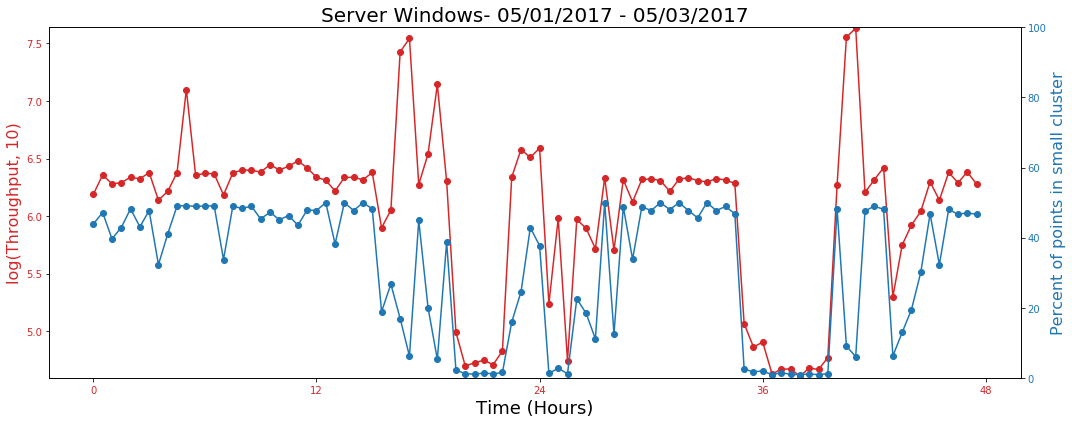

In [191]:
tput_change_compare(tput_avg_s_log_keep, 
                    tput_avg_s_log_disc, 
                    s_perMinority, 
                    0, 
                    '05/01/2017 - 05/03/2017', 
                    '05_01_2017', 
                    's')

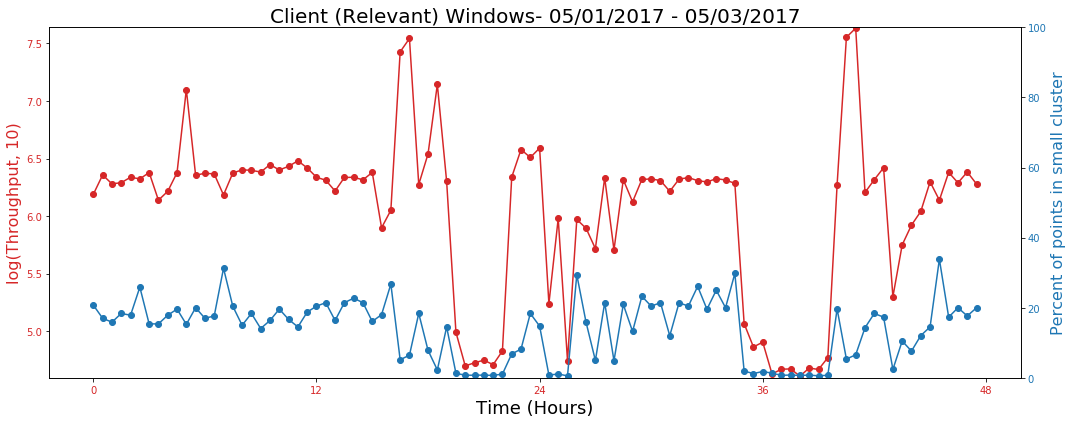

In [192]:
tput_change_compare(tput_avg_s_log_keep, 
                    tput_avg_s_log_disc, 
                    c_rel_perMinority, 
                    0, 
                    '05/01/2017 - 05/03/2017', 
                    '05_01_2017', 
                    'c_rel')

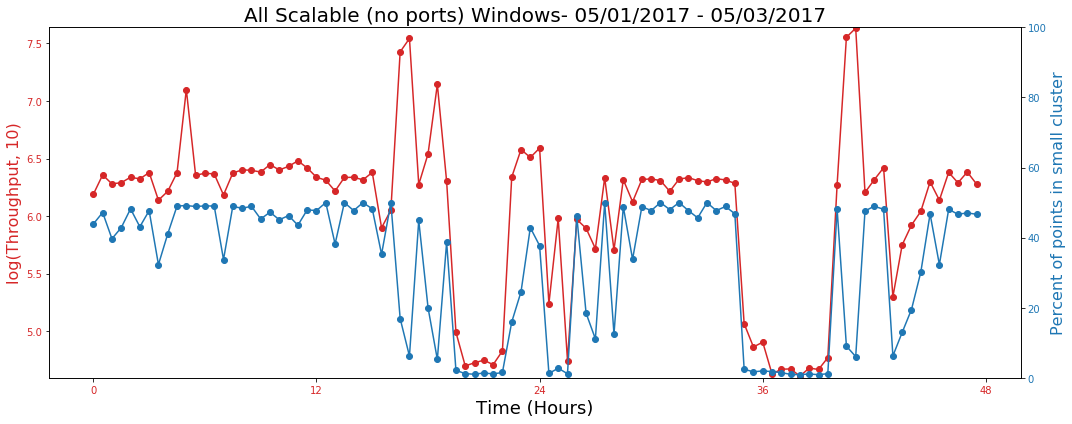

In [193]:
tput_change_compare(tput_avg_s_log_keep, 
                    tput_avg_s_log_disc, 
                    no_ports_perMinority, 
                    0, 
                    '05/01/2017 - 05/03/2017', 
                    '05_01_2017', 
                    'no_ports')

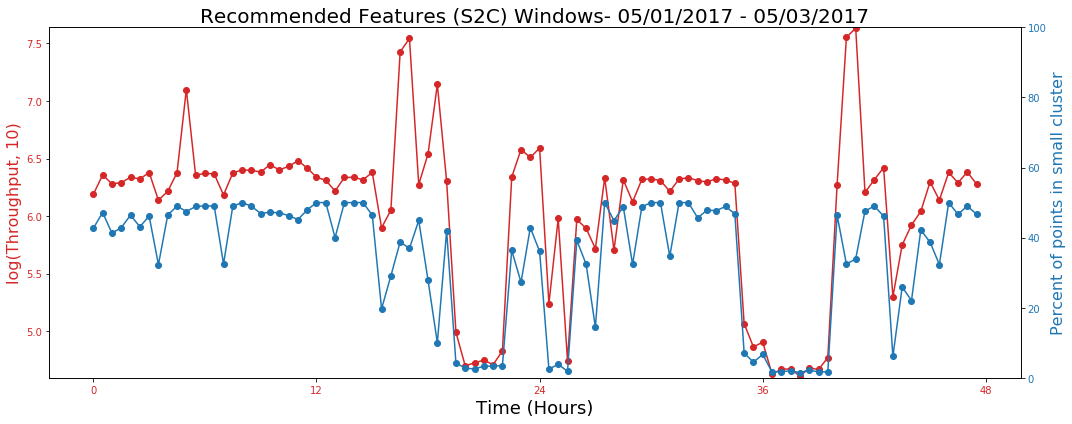

In [194]:
tput_change_compare(tput_avg_s_log_keep, 
                    tput_avg_s_log_disc, 
                    s_mar_perMinority, 
                    0, 
                    '05/01/2017 - 05/03/2017', 
                    '05_01_2017', 
                    's_mar')

In [126]:
s_perMinority_disc = map(lambda x: (x-min(s_perMinority))/(max(s_perMinority)-min(s_perMinority)), (s_perMinority[:749]+s_perMinority[755:]))
c_rel_perMinority_disc = map(lambda x: (x-min(c_rel_perMinority))/(max(c_rel_perMinority)-min(c_rel_perMinority)), (c_rel_perMinority[:749]+c_rel_perMinority[755:]))
no_ports_perMinority_disc = map(lambda x: (x-min(no_ports_perMinority))/(max(no_ports_perMinority)-min(no_ports_perMinority)), (no_ports_perMinority[:749]+no_ports_perMinority[755:]))
s_mar_perMinority_disc = map(lambda x: (x-min(s_mar_perMinority))/(max(s_mar_perMinority)-min(s_mar_perMinority)), (s_mar_perMinority[:749]+s_mar_perMinority[755:]))

tput_avg_s_log_disc_scaled = map(lambda x: (x-min(tput_avg_s_log_disc))/(max(tput_avg_s_log_disc)-min(tput_avg_s_log_disc)), tput_avg_s_log_disc)

In [127]:
def lessthan_1Mb(X):
    s=[None]*len(X)
    tput = [None]*len(X)
    j=0
    k=0
    for i in tput_avg_s_log_disc_scaled:
        if i<(6-min(tput_avg_s_log_disc))/(max(tput_avg_s_log_disc)-min(tput_avg_s_log_disc)):
            s[j]=X[k]
            tput[j]=i
            j=j+1
        k=k+1
    s = s[:j]
    tput = tput[:j]
    return [s, tput]

In [128]:
s_lowest25 = lessthan_1Mb(s_perMinority_disc)
c_rel_lowest25 = lessthan_1Mb(c_rel_perMinority_disc)
no_ports_lowest25 = lessthan_1Mb(no_ports_perMinority_disc)
s_mar_lowest25 = lessthan_1Mb(s_mar_perMinority_disc)

In [129]:
sum(tput_avg_s_log_disc_scaled)/len(tput_avg_s_log_disc_scaled)

0.5581128017634756

In [130]:
print len(s_lowest25[0])
print len(s_lowest25[0])/len(s_perMinority_disc)
print
print max(s_lowest25[0])
print max(c_rel_lowest25[0])
print max(no_ports_lowest25[0])
print max(s_mar_lowest25[0])

233
0.157326130993

0.970927945646
1.0
0.970915823957
0.978636801541


In [131]:
rmse25 = [None]*4
rmse25[0] = math.sqrt(MSRE(s_lowest25[0], s_lowest25[1]))
rmse25[1] = math.sqrt(MSRE(c_rel_lowest25[0], c_rel_lowest25[1]))
rmse25[2] = math.sqrt(MSRE(no_ports_lowest25[0], no_ports_lowest25[1]))
rmse25[3] = math.sqrt(MSRE(s_mar_lowest25[0], s_mar_lowest25[1]))

ksTest25 = [None]*4
ksTest25[0] = stats.ks_2samp(s_lowest25[0], s_lowest25[1])
ksTest25[1] = stats.ks_2samp(c_rel_lowest25[0], c_rel_lowest25[1])
ksTest25[2] = stats.ks_2samp(no_ports_lowest25[0], no_ports_lowest25[1])
ksTest25[3] = stats.ks_2samp(s_mar_lowest25[0], s_mar_lowest25[1])

In [132]:
s_lowest25_scaled = [s_lowest25[0], map(lambda x: (x-min(s_lowest25[1]))/(max(s_lowest25[1])-min(s_lowest25[1])), s_lowest25[1])]
c_rel_lowest25_scaled = [c_rel_lowest25[0], map(lambda x: (x-min(c_rel_lowest25[1]))/(max(c_rel_lowest25[1])-min(c_rel_lowest25[1])), c_rel_lowest25[1])]
no_ports_lowest25_scaled = [no_ports_lowest25[0], map(lambda x: (x-min(no_ports_lowest25[1]))/(max(no_ports_lowest25[1])-min(no_ports_lowest25[1])), no_ports_lowest25[1])]
s_mar_lowest25_scaled = [s_mar_lowest25[0], map(lambda x: (x-min(s_mar_lowest25[1]))/(max(s_mar_lowest25[1])-min(s_mar_lowest25[1])), s_mar_lowest25[1])]

In [133]:
print rmse25
print ksTest25

[0.1666936455251828, 0.24465339922361778, 0.18486795230195405, 0.19036710469014148]
[Ks_2sampResult(statistic=0.3562231759656653, pvalue=1.4086978969068651e-13), Ks_2sampResult(statistic=0.6223175965665236, pvalue=1.4484845438749678e-40), Ks_2sampResult(statistic=0.3175965665236052, pvalue=7.022031438729296e-11), Ks_2sampResult(statistic=0.2918454935622318, pvalue=2.972132652155664e-09)]


In [134]:
def cdf(X):
    sort = map(lambda x: sorted(x), X)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(map(lambda x: x, sort[0]), map(lambda x: x/len(X[0]), range(0,len(X[0]))), 'bo')
    ax2.plot(sort[1], map(lambda x: x/len(X[1]), range(0,len(X[1]))), 'bo')
    print plt.show()

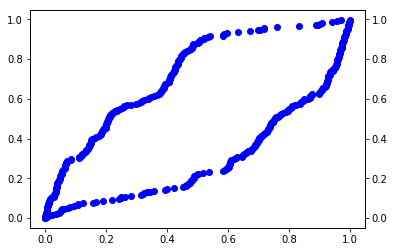

None


In [135]:
cdf(s_lowest25_scaled)

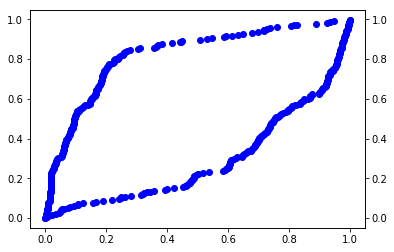

None


In [136]:
cdf(c_rel_lowest25_scaled)

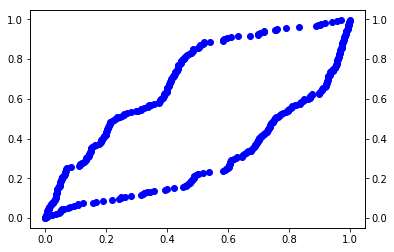

None


In [137]:
cdf(no_ports_lowest25_scaled)

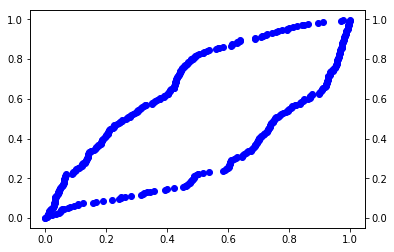

None


In [138]:
cdf(s_mar_lowest25_scaled)